## 1. 檢查 GPU
首先確定我們可以使用 GPU。我們可以使用 nvidia-smi 命令來檢查。如果出現錯誤訊息，請前往「編輯」->「筆記本設定」->「硬體加速器」，將其設置為 GPU，然後點擊保存。

In [1]:
!nvidia-smi

Sun Jun  2 05:31:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 2. 訓練自己的 YOLOv10 模型
### 2.1 下載/安裝 YOLOv10

In [2]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 55.4 MB/s eta 0:00:00


### 2.2 下載權重
YOLOv10 已經在 coco 數據集上訓練過，該數據集包含 80 個可預測的類別。我們將獲取這些預訓練權重，以便可以在這些預訓練類別上運行物件辨識。您可以從以下連結查看預訓練的 YOLOv10 權重可以檢測到哪些類別。

- [COCO CLASSES](http://cocodataset.org/#explore)

| Model | Test Size | #Params | FLOPs | AP<sup>val</sup> | Latency |
|:---------------|:----:|:---:|:--:|:--:|:--:|
| [YOLOv10-N](https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt) |   640  |     2.3M    |   6.7G   |     38.5%     | 1.84ms |
| [YOLOv10-S](https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt) |   640  |     7.2M    |   21.6G  |     46.3%     | 2.49ms |
| [YOLOv10-M](https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt) |   640  |     15.4M   |   59.1G  |     51.1%     | 4.74ms |
| [YOLOv10-B](https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt) |   640  |     19.1M   |  92.0G |     52.5%     | 5.74ms |
| [YOLOv10-L](https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt) |   640  |     24.4M   |  120.3G   |     53.2%     | 7.28ms |
| [YOLOv10-X](https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt) |   640  |     29.5M    |   160.4G   |     54.4%     | 10.70ms |


In [3]:
!wget -P /content/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P /content/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P /content/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P /content/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P /content/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!wget -P /content/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt

### 2.3 使用 Roboflow 匯入資料集

In [4]:
!pip install roboflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 991.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.4 MB/s eta 0:00:00


In [5]:
from roboflow import Roboflow
rf = Roboflow(api_key="8Z4ck3hgIdLkrbFet3Yj")
project = rf.workspace("yolo-zbpxw").project("screw-fmzbb")
version = project.version(4)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to screw-4 in yolov8:: 100%|██████████| 122/122 [00:00<00:00, 2652.85it/s]


**NOTE:**
Make sure the last 4 lines of the data.yaml file have the following format:

```
test: ../test/images
train: ../train/images
val: ../valid/images
```

If using a dataset from Roboflow Universe, run the command below. 👇🏻

In [6]:
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

### 2.4 訓練模型

In [7]:
from ultralytics import YOLO

model = YOLO('/content/weights/yolov10m.pt')

results = model.train(data=f"{dataset.location}/data.yaml", epochs=100, imgsz=640)

New https://pypi.org/project/ultralytics/8.2.27 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10m.pt, data=/content/screw-4/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False

100%|██████████| 755k/755k [00:00<00:00, 15.1MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1     78720  ultralytics.nn.modules.block.SCDown          [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1    228672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 78.5MB/s]
Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)


AMP: checks passed ✅


train: Scanning /content/screw-4/train/labels... 48 images, 0 backgrounds, 0 corrupt: 100%|██████████| 48/48 [00:00<00:00, 1150.87it/s]

train: New cache created: /content/screw-4/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/screw-4/valid/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1848.53it/s]

val: New cache created: /content/screw-4/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)
TensorBoard: WARNING ⚠️ TensorBoard graph visualization failure 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      1/100      9.57G      1.605      4.437      1.543       1.61       15.5      1.533         37        640: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]

                   all          5         11      0.512      0.452      0.271      0.228



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      2/100      9.55G      1.644       5.24      1.618      1.623      19.92      1.562         35        640: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

                   all          5         11      0.685      0.375       0.21      0.176



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      3/100      9.57G      1.659      4.631      1.628      1.594      15.49      1.515         33        640: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all          5         11      0.727        0.5      0.275      0.231



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      4/100      9.63G      1.822      4.648      1.804      1.721       14.5      1.697         40        640: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all          5         11      0.819      0.125      0.252      0.195



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      5/100      9.75G      1.586      3.001      1.524      1.439      9.718      1.314         30        640: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


                   all          5         11      0.667      0.271      0.374      0.256

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      6/100      9.71G      1.661      2.894      1.533      1.557      8.269      1.422         29        640: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

                   all          5         11      0.714      0.333      0.648      0.411



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      7/100      9.74G      1.577      2.147      1.504      1.489      6.228      1.428         30        640: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all          5         11      0.782      0.375      0.482      0.202



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      8/100      9.77G      1.692      2.509      1.574      1.554      6.148      1.469         42        640: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all          5         11      0.505      0.729      0.651      0.446



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      9/100      9.74G        1.5      2.059      1.412      1.523      4.892      1.396         45        640: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


                   all          5         11      0.547      0.438      0.353      0.246

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     10/100      9.72G      1.739      2.303      1.539       1.62      4.528      1.448         34        640: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all          5         11      0.771        0.5      0.702      0.475



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     11/100      9.77G      1.586      1.868      1.502      1.599      3.921      1.495         29        640: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all          5         11      0.589      0.574      0.694      0.413



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     12/100      9.74G      1.973      2.074      1.855      1.928      4.009      1.787         22        640: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

                   all          5         11      0.932       0.25      0.542      0.352



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     13/100      9.75G      1.899      1.954      1.693      1.845       3.38      1.562         60        640: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all          5         11      0.643      0.475      0.604      0.384



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     14/100      9.74G      1.733      1.706      1.616      1.729      2.833      1.544         49        640: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


                   all          5         11      0.508      0.312      0.428      0.311

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     15/100      9.76G      1.706      1.679      1.503       1.82      2.705      1.514         32        640: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


                   all          5         11      0.987      0.125      0.124      0.102

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     16/100      9.74G      1.638      1.546      1.557      1.673      2.361      1.479         45        640: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all          5         11    0.00212      0.125     0.0212     0.0106



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     17/100      9.74G      1.786      1.821      1.626      1.808      2.544      1.538         37        640: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

                   all          5         11    0.00212      0.125     0.0212     0.0106



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     18/100      9.72G      1.804      2.062       1.81      1.837      2.584      1.775         38        640: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all          5         11    0.00212      0.125     0.0212     0.0106



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     19/100      9.74G      1.648      1.673       1.52      1.671      2.168      1.463         38        640: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


                   all          5         11    0.00212      0.125     0.0212     0.0106

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     20/100      9.76G      1.623      1.439      1.464      1.649      1.883      1.421         35        640: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

                   all          5         11    0.00212      0.125     0.0212     0.0106



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     21/100      9.74G      1.723      1.517      1.649      1.786      1.952      1.624         39        640: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all          5         11    0.00212      0.125     0.0212     0.0106



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     22/100      9.74G      1.542      1.473      1.415      1.553      1.834      1.383         28        640: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all          5         11    0.00212      0.125     0.0212     0.0106



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     23/100      9.74G      1.624      1.468      1.475      1.802      1.684      1.508         43        640: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all          5         11      0.236      0.125      0.132     0.0806



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     24/100      9.73G      1.491      1.724      1.488      1.627      2.386      1.487         31        640: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


                   all          5         11      0.266      0.309      0.186     0.0907

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     25/100      9.72G      1.612       1.33      1.411      1.777      1.599      1.441         29        640: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all          5         11       0.24      0.125      0.136     0.0526



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     26/100      9.74G      1.381      1.513      1.316      1.512      1.873      1.329         32        640: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all          5         11      0.323      0.333      0.367      0.198



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     27/100      9.74G      1.614      1.475      1.398      1.721      1.424      1.416         41        640: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

                   all          5         11       0.53       0.59      0.572       0.32



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     28/100      9.74G      1.668      1.527       1.59      1.684      1.505      1.534         42        640: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

                   all          5         11       0.91       0.25      0.427      0.263



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     29/100      9.74G      1.517      1.577       1.49      1.691      1.592      1.498         53        640: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all          5         11       0.91       0.25      0.427      0.263



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     30/100      9.75G      1.709      1.581      1.522      1.775      1.879      1.501         42        640: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


                   all          5         11      0.329      0.671      0.556      0.395

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     31/100      9.74G      1.609      1.606      1.518      1.685      1.571      1.489         33        640: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all          5         11      0.546       0.53      0.452      0.292



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     32/100      9.75G      1.632      1.574      1.573      1.873      1.583      1.613         37        640: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all          5         11      0.848       0.25      0.246      0.136



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     33/100      9.74G      1.564      1.734      1.465      1.727       1.79      1.512         34        640: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


                   all          5         11      0.848       0.25      0.246      0.136

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     34/100      9.75G      1.465      1.908      1.373      1.743      2.163      1.498         26        640: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

                   all          5         11      0.253      0.417     0.0075    0.00268



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     35/100      9.74G      1.645      1.852       1.48      1.823      2.018      1.521         35        640: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all          5         11      0.506      0.125    0.00433   0.000719



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     36/100      9.73G      1.593      1.718      1.532      1.743      1.867      1.552         37        640: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all          5         11      0.518      0.125     0.0118    0.00638



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     37/100      9.72G      1.727      1.515      1.674      1.958      1.614      1.698         43        640: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all          5         11      0.518      0.125     0.0118    0.00638

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     38/100      9.73G      1.804      1.668      1.633       1.71      1.841      1.573         32        640: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all          5         11          1      0.237      0.319      0.199



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     39/100      9.73G      1.625      1.715      1.595      1.736       1.76      1.523         30        640: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all          5         11      0.824      0.375      0.493      0.231



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     40/100      9.75G        1.8      1.635      1.591      1.765      1.601      1.551         32        640: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]

                   all          5         11      0.494      0.188      0.231     0.0677



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     41/100      9.75G      1.522      1.517      1.456      1.765      1.541      1.496         39        640: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

                   all          5         11      0.494      0.188      0.231     0.0677



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     42/100      9.75G      1.569      1.441      1.381      1.701      1.512      1.382         47        640: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all          5         11      0.602      0.188      0.312      0.177



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     43/100      9.77G       1.64      1.464      1.501       1.71       1.46      1.492         34        640: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all          5         11      0.774      0.188      0.292      0.135



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     44/100      9.75G      1.618      1.417      1.509      1.747      1.591      1.516         33        640: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

                   all          5         11      0.666       0.25       0.28      0.126



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     45/100      9.76G      1.565      1.396      1.513      1.635      1.544      1.516         25        640: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

                   all          5         11      0.666       0.25       0.28      0.126



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     46/100      9.75G      1.729        1.4      1.536      1.871      1.564      1.535         32        640: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all          5         11     0.0899      0.375      0.116     0.0657



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     47/100      9.73G      1.598      1.301       1.42      1.668      1.568      1.406         54        640: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]

                   all          5         11      0.581       0.25       0.31      0.182



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     48/100      9.75G      1.728      1.435      1.625      1.844      1.738      1.614         49        640: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all          5         11      0.565       0.48      0.487      0.283



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     49/100      9.74G      1.817      1.501      1.713      1.952      1.587      1.725         33        640: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all          5         11      0.565       0.48      0.487      0.283



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     50/100      9.75G      1.623      1.337      1.477      1.702      1.394       1.47         40        640: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all          5         11      0.666      0.487      0.505      0.277



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     51/100      9.74G       1.52      1.254      1.393      1.666      1.352      1.431         36        640: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

                   all          5         11        0.2       0.52       0.24      0.134



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     52/100      9.75G      1.553      1.263      1.414      1.673       1.35      1.446         54        640: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all          5         11      0.464      0.208      0.421      0.321



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     53/100      9.74G      1.654      1.347      1.589      1.828      1.561      1.597         42        640: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all          5         11      0.464      0.208      0.421      0.321



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     54/100      9.73G      1.666      1.224      1.508      1.773      1.344      1.471         46        640: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

                   all          5         11      0.583      0.333      0.603      0.475



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     55/100      9.75G      1.611      1.193      1.389      1.809      1.345      1.454         30        640: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


                   all          5         11      0.384      0.721      0.647        0.4

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     56/100      9.75G      1.731      1.289      1.516      1.887      1.223      1.558         37        640: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all          5         11      0.589      0.725      0.711      0.501



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     57/100      9.72G      1.587      1.234      1.526      1.735      1.284      1.564         33        640: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


                   all          5         11      0.589      0.725      0.711      0.501

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     58/100      9.75G      1.623      1.314      1.485      1.721      1.426      1.503         39        640: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


                   all          5         11      0.508      0.858      0.861      0.609

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     59/100      9.75G      1.593      1.314      1.504      1.762      1.365      1.553         40        640: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all          5         11      0.668      0.744      0.846      0.555



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     60/100      9.73G      1.655      1.262       1.57      1.807      1.502      1.623         26        640: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]

                   all          5         11      0.632      0.788      0.834      0.544



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     61/100      9.75G      1.474      1.217      1.462      1.697      1.284      1.555         29        640: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all          5         11      0.632      0.788      0.834      0.544



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     62/100      9.75G      1.508       1.25      1.425      1.728      1.426      1.492         34        640: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

                   all          5         11      0.613      0.854      0.847      0.528



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     63/100      9.74G      1.521      1.199      1.517      1.663      1.243      1.522         31        640: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all          5         11      0.555      0.846      0.815      0.511



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     64/100      9.75G      1.636       1.23      1.396      1.813      1.359      1.446         42        640: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

                   all          5         11      0.757      0.795      0.862      0.586



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     65/100      9.72G      1.448      1.201      1.326       1.68       1.33      1.394         30        640: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all          5         11      0.757      0.795      0.862      0.586



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     66/100      9.75G      1.597      1.213       1.37       1.69      1.325      1.347         30        640: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]

                   all          5         11      0.737       0.75      0.811      0.485



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     67/100      9.78G      1.464      1.148      1.366      1.614      1.284      1.439         47        640: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

                   all          5         11      0.646      0.857      0.885      0.446



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     68/100      9.75G      1.405      1.122      1.322      1.617      1.296      1.407         34        640: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

                   all          5         11      0.667      0.938      0.891      0.455



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     69/100      9.74G      1.473      1.139      1.359      1.572      1.264      1.403         36        640: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]

                   all          5         11      0.667      0.938      0.891      0.455



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     70/100      9.75G      1.436      1.096      1.368      1.605      1.249      1.409         30        640: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all          5         11      0.648      0.938      0.891       0.46



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     71/100      9.73G      1.472      1.144      1.391      1.492       1.23      1.366         32        640: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


                   all          5         11      0.606      0.646      0.798      0.423

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     72/100      9.75G      1.476      1.075      1.419      1.647      1.294      1.444         45        640: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

                   all          5         11      0.719      0.521      0.609      0.296



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     73/100      9.74G      1.442      1.088       1.45      1.584      1.115      1.425         32        640: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all          5         11      0.719      0.521      0.609      0.296



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     74/100      9.75G      1.543      1.147      1.509      1.588      1.303      1.439         41        640: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


                   all          5         11      0.382      0.768      0.594      0.304

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     75/100      9.75G      1.448      1.105      1.414      1.576      1.143      1.434         24        640: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


                   all          5         11      0.719      0.751      0.761      0.428

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     76/100      9.77G      1.473      1.133      1.358      1.716      1.208      1.403         25        640: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

                   all          5         11      0.748      0.792      0.808      0.471



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     77/100      9.77G      1.392      1.034      1.316       1.56          1      1.329         45        640: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


                   all          5         11      0.748      0.792      0.808      0.471

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     78/100      9.75G      1.398      1.037       1.29      1.597       1.11      1.326         38        640: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


                   all          5         11      0.616      0.875      0.796      0.448

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     79/100      9.74G      1.526      1.086      1.411       1.59     0.9653      1.385         30        640: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


                   all          5         11      0.718      0.836      0.846      0.516

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     80/100      9.73G      1.425      1.045      1.403      1.463      1.141      1.447         40        640: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

                   all          5         11      0.893      0.944      0.995      0.544



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     81/100      9.72G      1.561      1.006      1.353      1.612      1.012       1.32         43        640: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all          5         11      0.893      0.944      0.995      0.544



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     82/100      9.77G      1.434     0.9915      1.314      1.583     0.9915      1.333         36        640: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


                   all          5         11      0.786       0.95      0.953      0.553

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     83/100      9.75G      1.502     0.9852      1.429      1.607      1.064      1.438         30        640: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


                   all          5         11      0.936       0.89      0.995      0.617

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     84/100      9.75G      1.474     0.9586      1.449      1.649      1.006       1.48         41        640: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

                   all          5         11       0.92       0.88      0.974      0.601



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     85/100      9.74G       1.52      1.052      1.437      1.585      1.161      1.463         35        640: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


                   all          5         11       0.92       0.88      0.974      0.601

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     86/100      9.73G      1.288     0.9338      1.324      1.518     0.9485      1.405         55        640: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

                   all          5         11      0.865       0.77      0.926      0.564



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     87/100      9.74G      1.334     0.9186      1.278      1.476     0.9693      1.333         37        640: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all          5         11      0.938      0.563      0.885       0.46



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     88/100      9.75G      1.426      1.179      1.367       1.64      1.245      1.415         41        640: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


                   all          5         11      0.848      0.583       0.69      0.385

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     89/100      9.74G      1.519      1.078      1.528      1.627      1.237      1.506         29        640: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all          5         11      0.848      0.583       0.69      0.385



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     90/100      9.75G      1.317     0.9416      1.271      1.445     0.9293      1.316         25        640: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all          5         11      0.818      0.583      0.608      0.384


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     91/100      9.73G       1.37     0.9833      1.442      1.498     0.9243      1.509         21        640: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all          5         11       0.62      0.583      0.602      0.348



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     92/100      9.73G      1.257     0.8922      1.356      1.399     0.9177       1.42         19        640: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


                   all          5         11      0.808      0.583       0.64      0.402

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     93/100      9.73G      1.404     0.9618       1.37      1.417      1.184      1.406         24        640: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]

                   all          5         11      0.808      0.583       0.64      0.402



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     94/100      9.73G      1.289     0.9012      1.425       1.47      0.917      1.468         19        640: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


                   all          5         11      0.764      0.583      0.779      0.461

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     95/100      9.74G       1.31      1.078      1.552      1.461      1.206      1.625         21        640: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all          5         11      0.803      0.583      0.871      0.544



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     96/100      9.73G      1.273     0.8426      1.377      1.369     0.8745      1.438         19        640: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

                   all          5         11      0.629      0.984      0.887      0.537



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     97/100      9.72G      1.192     0.8264      1.308      1.328     0.8279       1.36         24        640: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all          5         11      0.629      0.984      0.887      0.537



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     98/100      9.74G      1.168     0.8474      1.257      1.271     0.8148      1.289         16        640: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


                   all          5         11      0.727      0.906      0.912      0.553

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     99/100      9.74G      1.125     0.8192       1.24      1.239     0.7292      1.254         16        640: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all          5         11      0.705      0.767      0.912      0.583



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


    100/100      9.73G      1.164     0.8157       1.31      1.317     0.7655       1.37         22        640: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


                   all          5         11      0.536       0.95        0.9      0.582

100 epochs completed in 0.123 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 33.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 33.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10m summary (fused): 369 layers, 16455016 parameters, 0 gradients, 63.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]


                   all          5         11      0.936       0.89      0.995      0.617
                class1          5          2      0.839          1      0.995      0.501
                class2          5          2          1          1      0.995      0.667
                class3          5          3          1      0.559      0.995      0.827
                class4          5          4      0.904          1      0.995      0.472
Speed: 0.3ms preprocess, 24.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train


In [8]:
## 亦可使用 CLI 指令進行模型訓練(Ultralytics API)
# !yolo task=detect mode=train epochs=100 batch=16 plots=True \
# model=/content/weights/yolov10n.pt \
# data={dataset.location}/data.yaml

### 2.5 評估模型

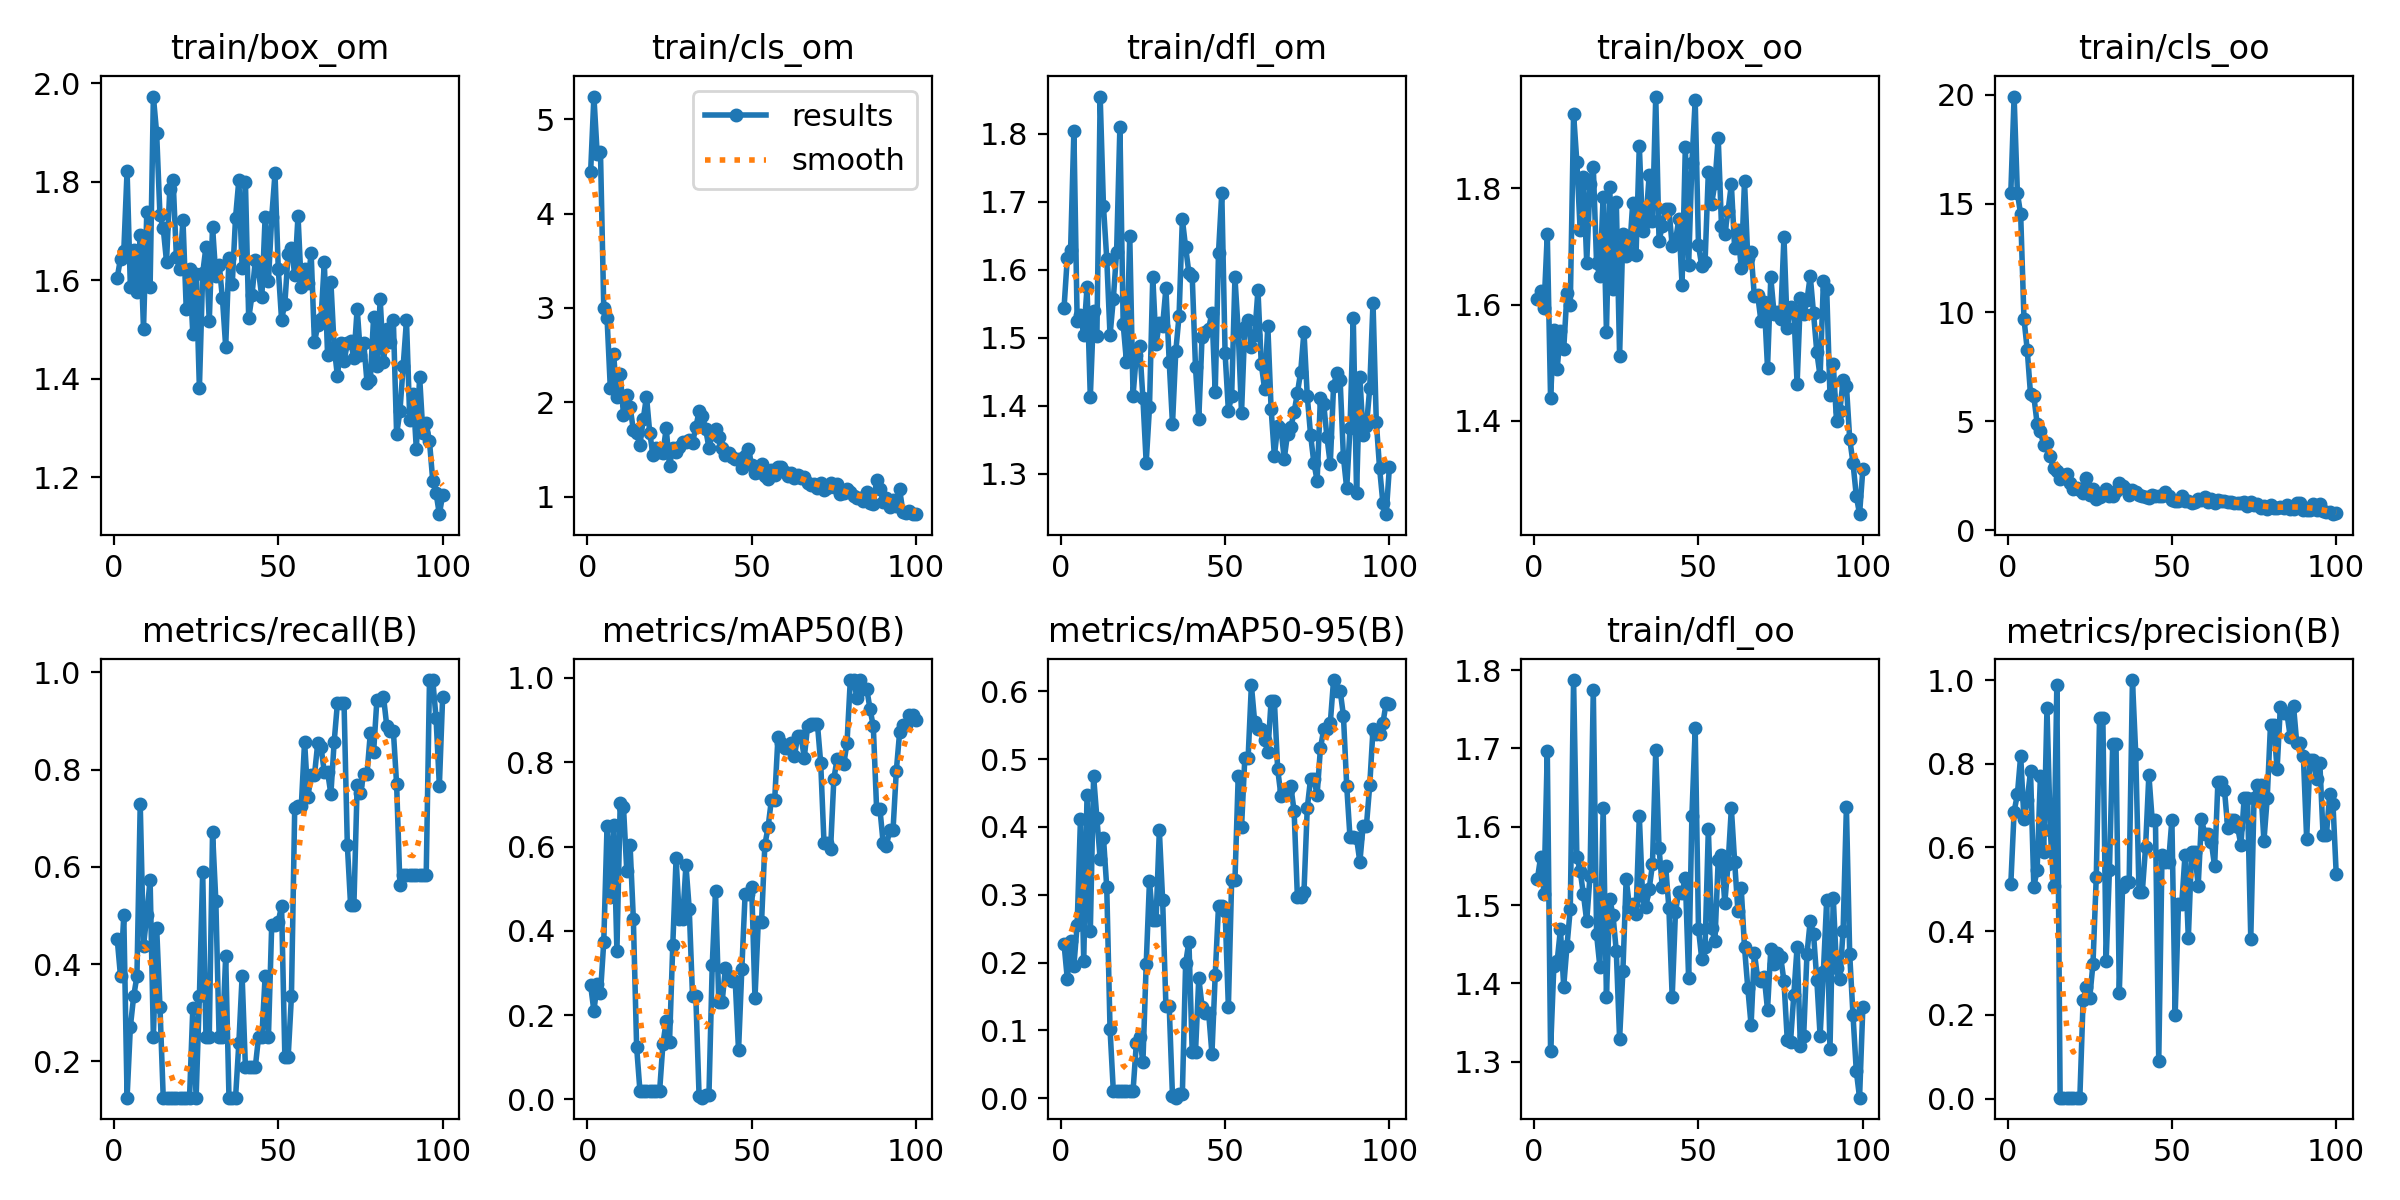

In [9]:
from IPython.display import Image

# 顯示訓練結果loss
Image(filename=f"/content/runs/detect/train/results.png", width=1000)

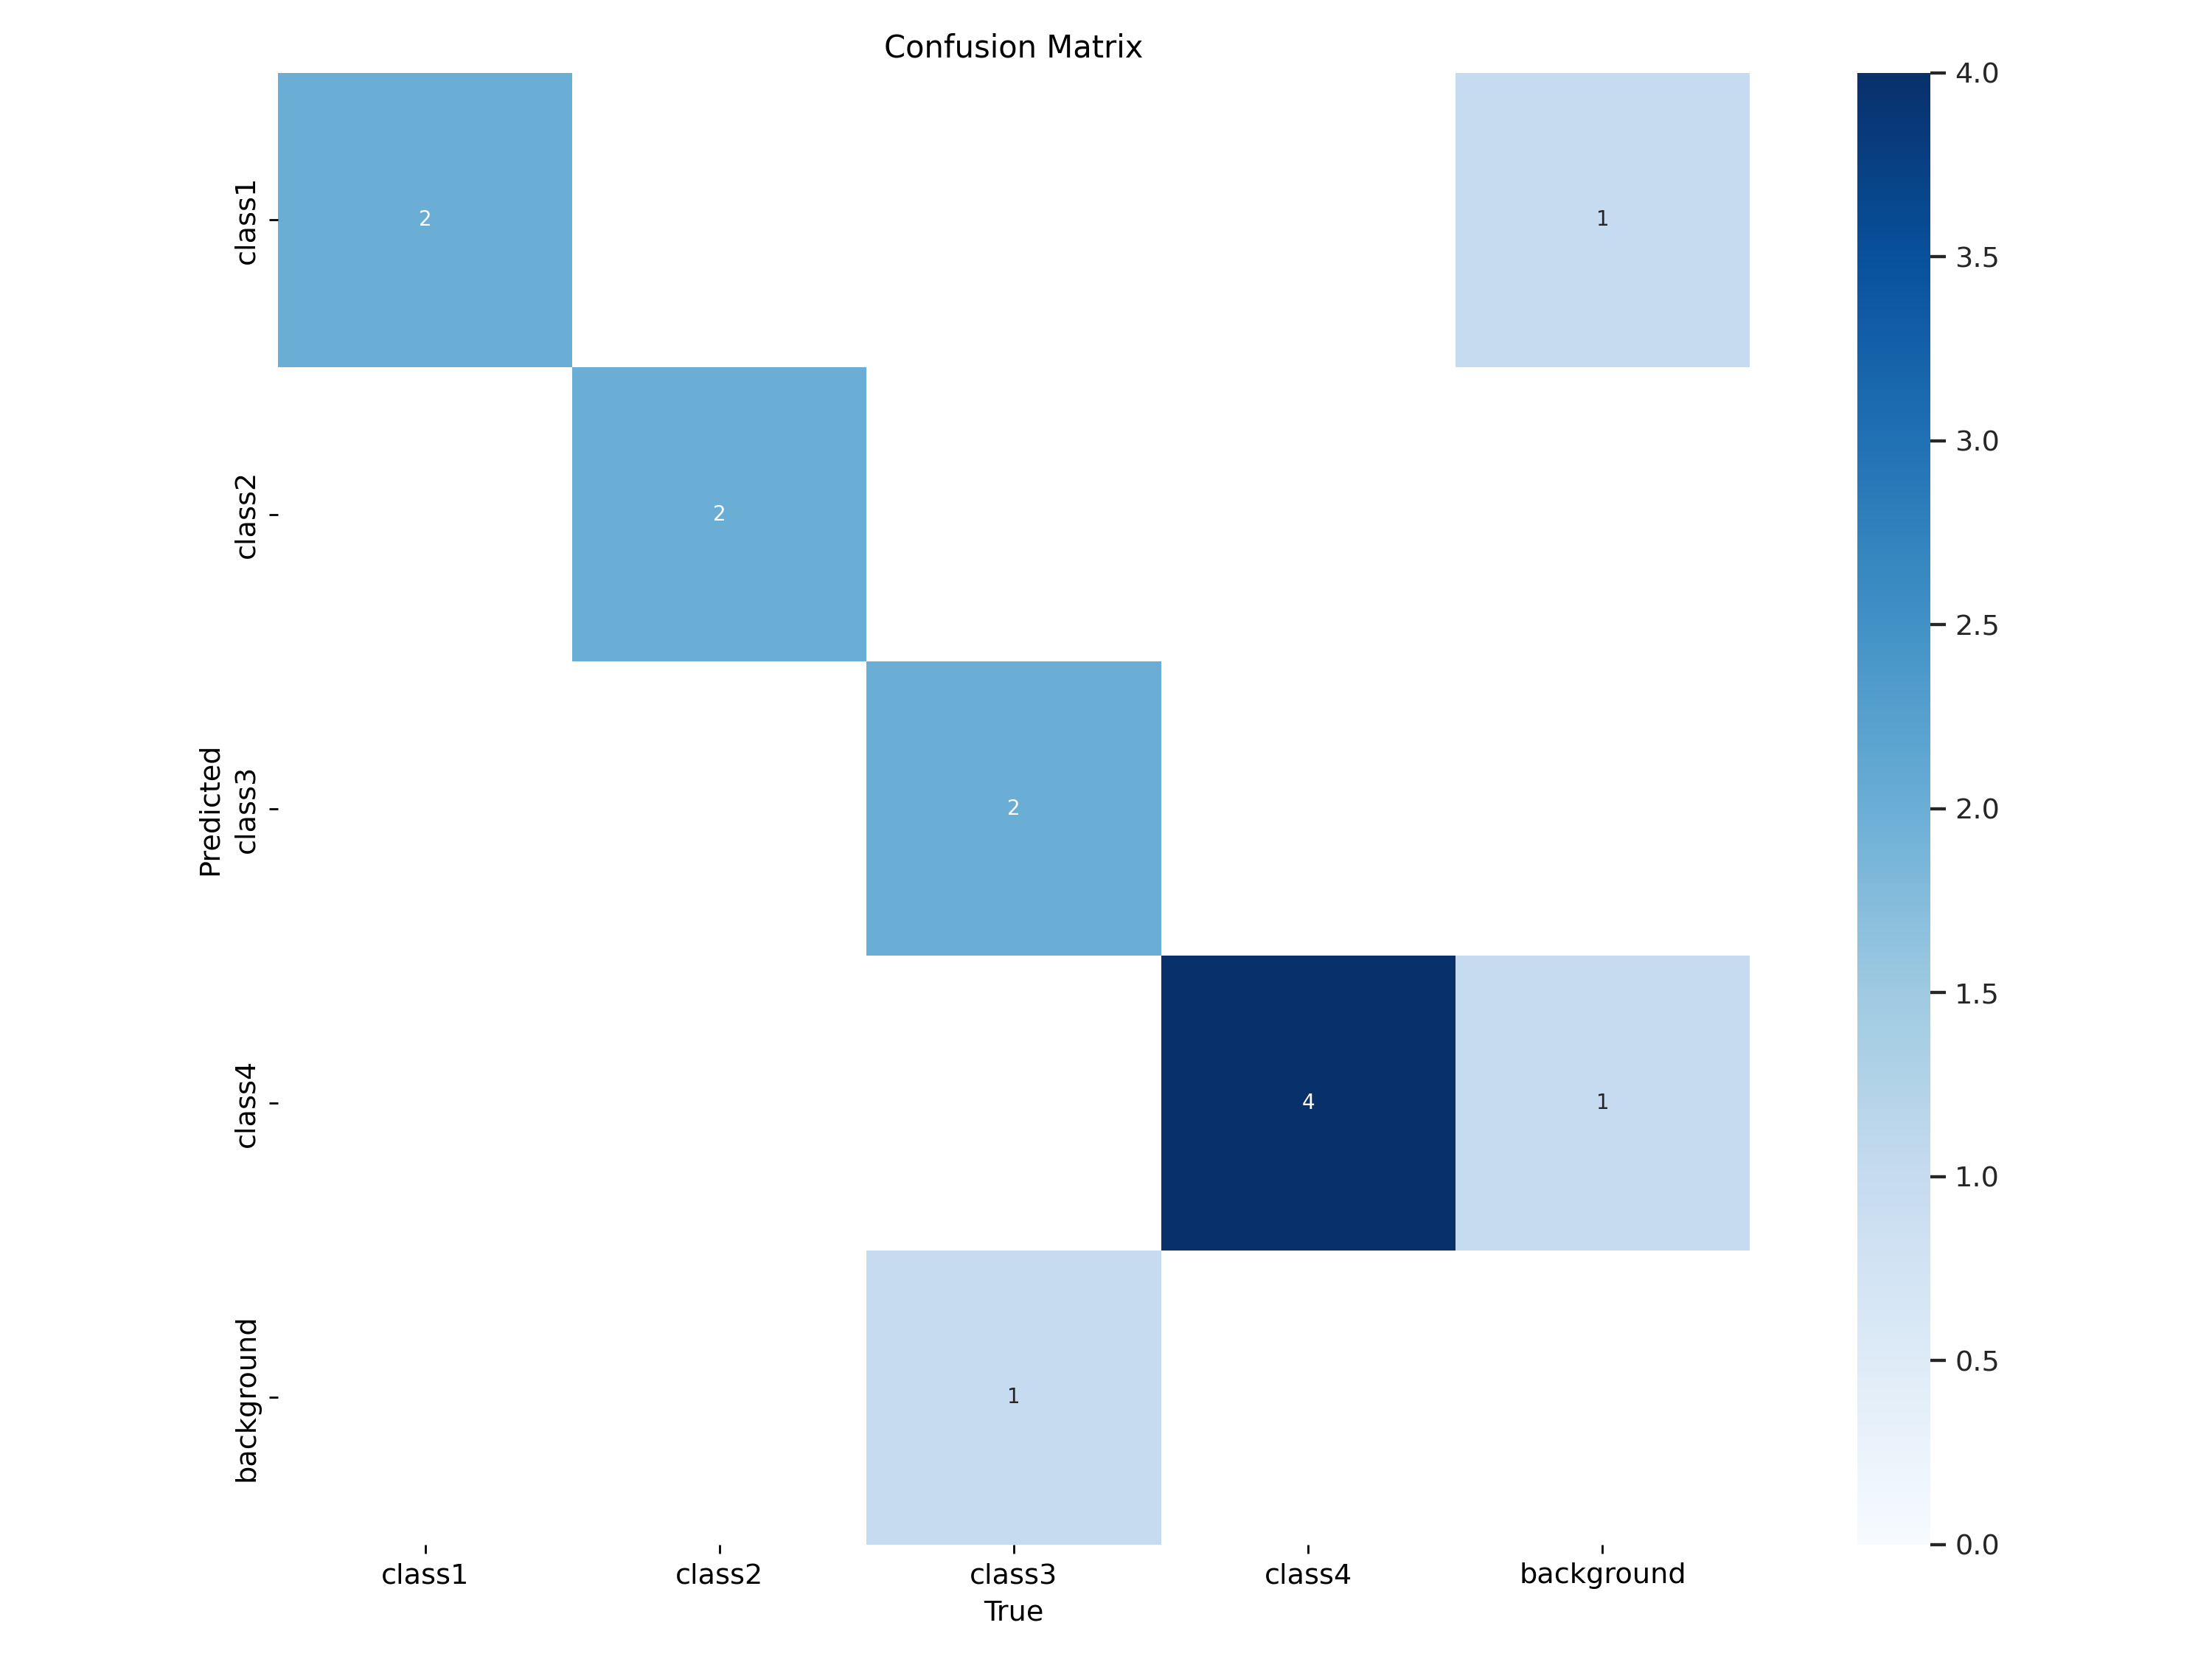

In [10]:
from IPython.display import Image

# 顯示訓練集混淆矩陣
Image(filename=f"/content/runs/detect/train/confusion_matrix.png", width=1000)

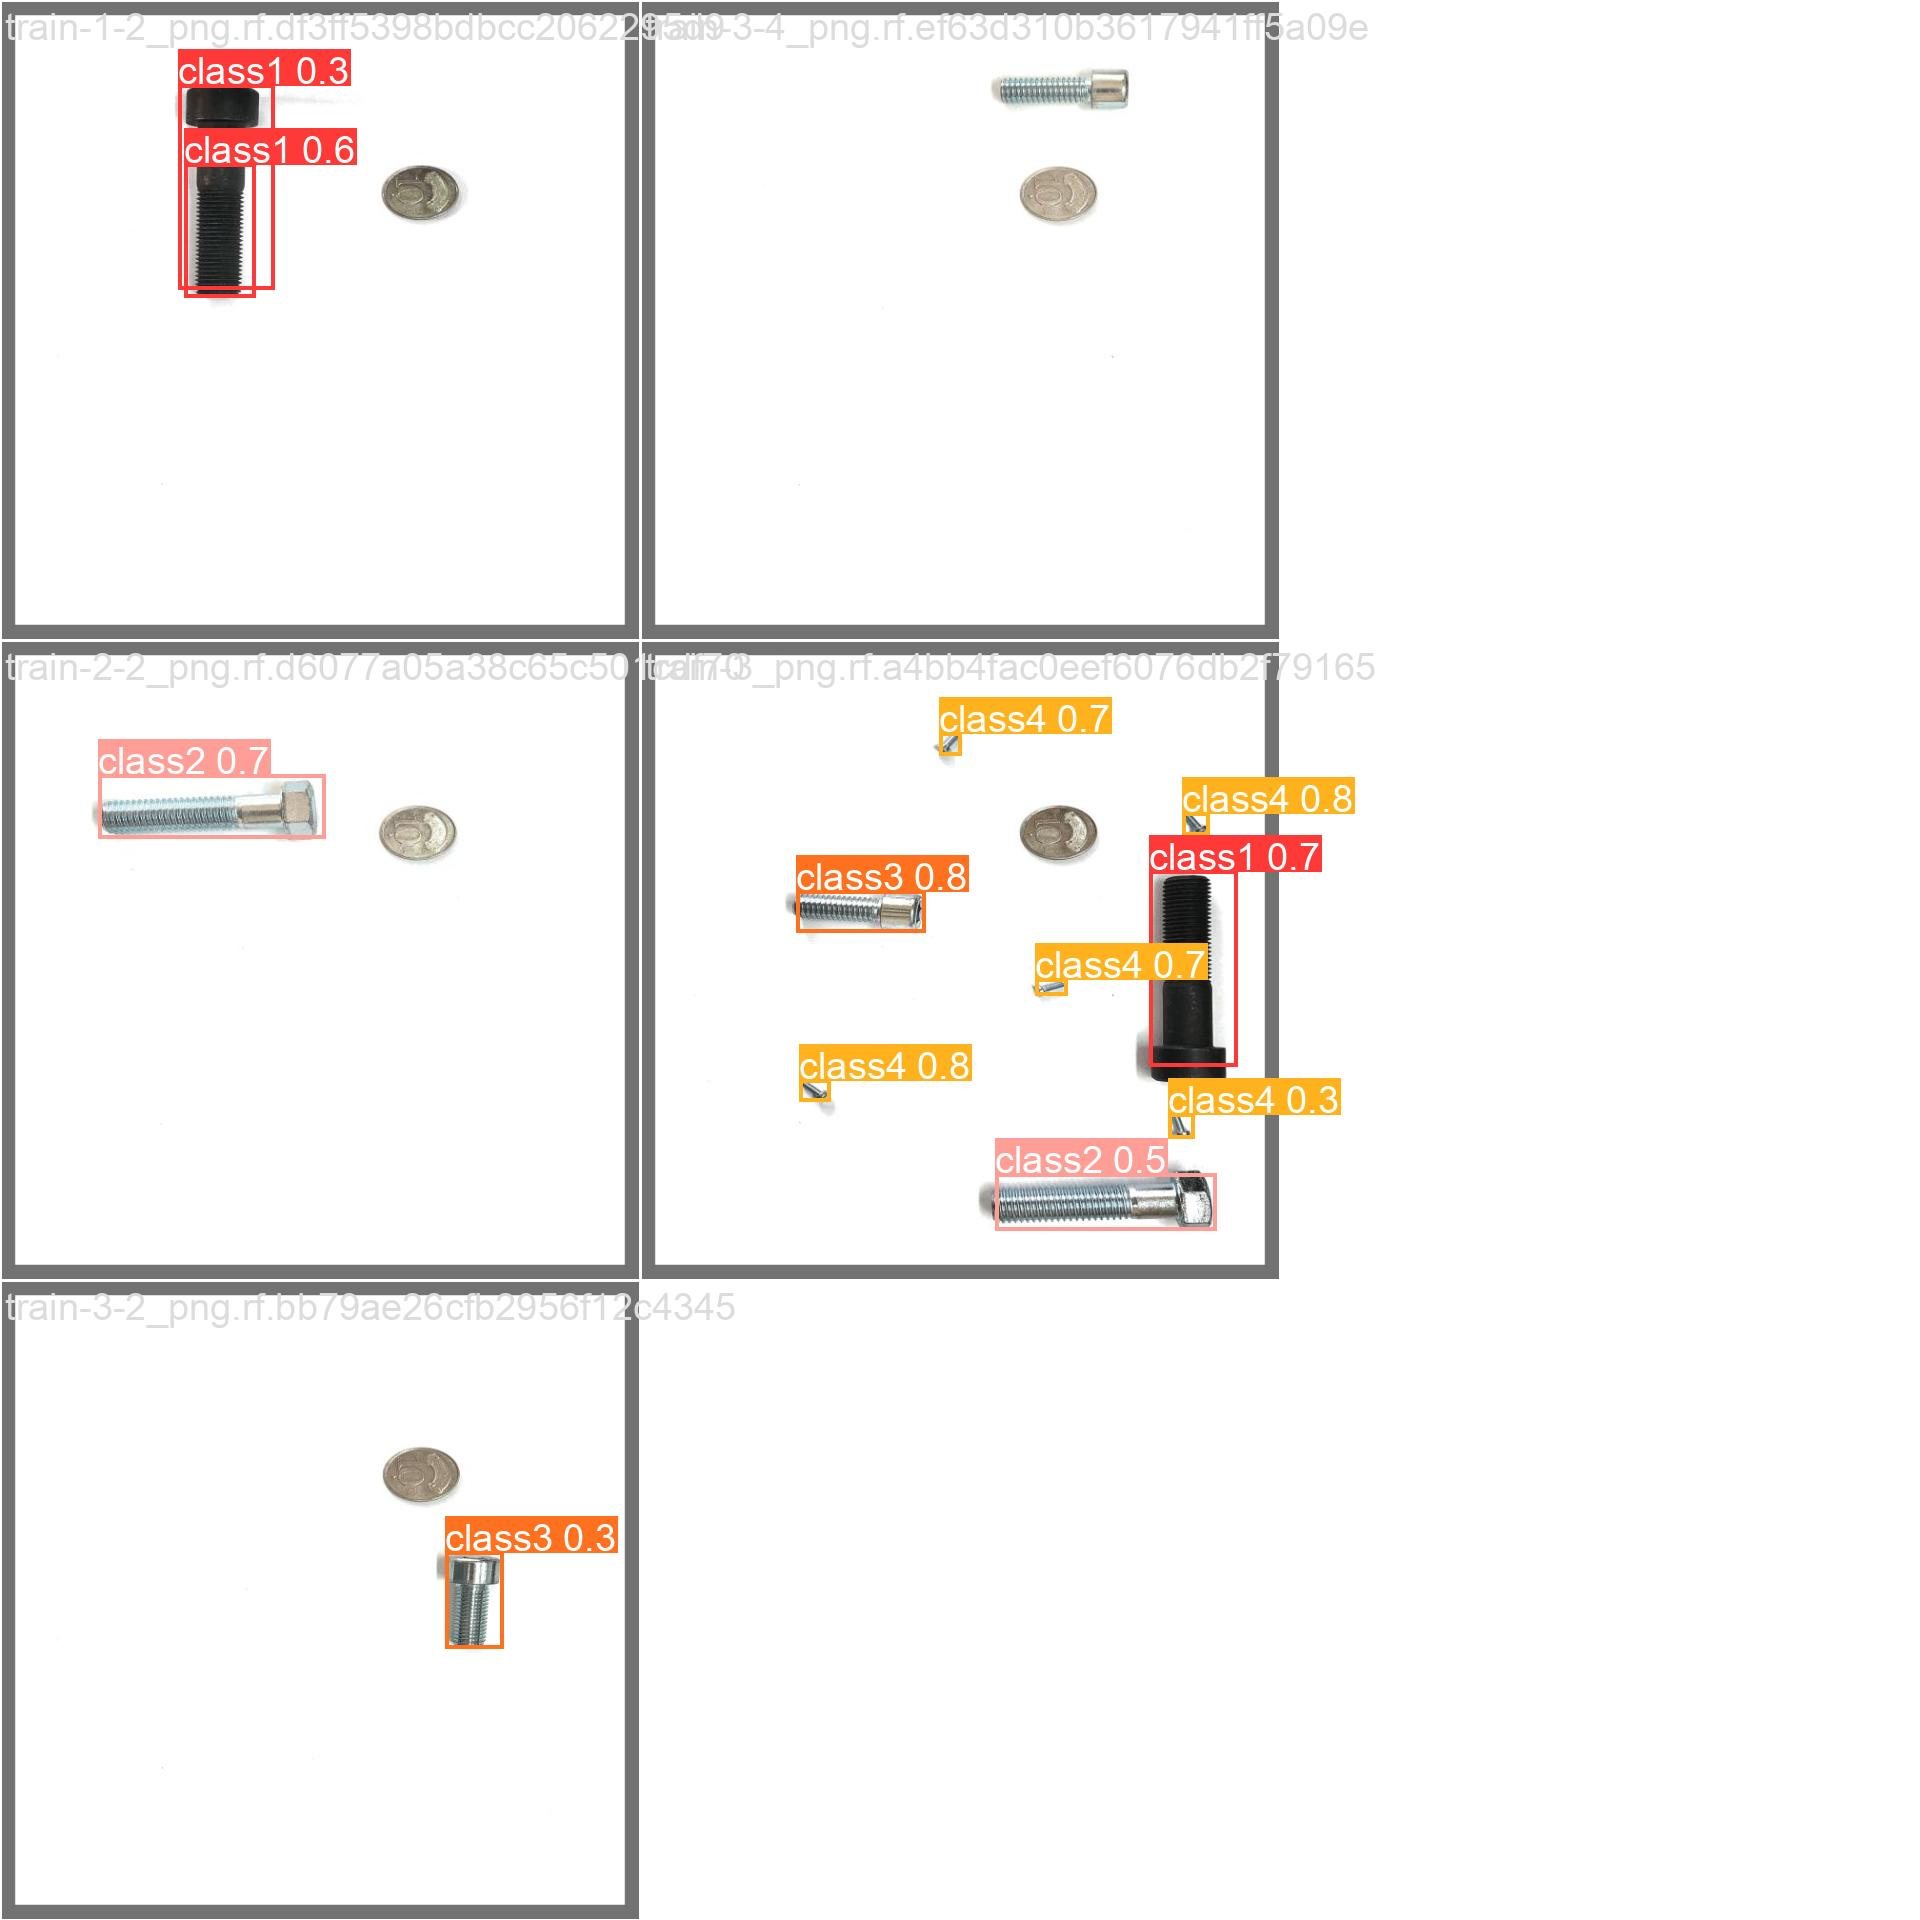

In [11]:
from IPython.display import Image

# 觀察驗證集預測結果
Image(filename=f"/content/runs/detect/train/val_batch0_pred.jpg", width=1000)

### 2.6 測試
### 2.6.1 使用 Ultralytics Python API 預測(方法一)
請注意要使用 ultralytics 的 YOLOv10 API 進行推論，如果使用到 YOLOv8 的函式會出現 `AttributeError: 'dict' object has no attribute 'shape'` 錯誤。

In [12]:
from ultralytics import YOLOv10

model = YOLOv10('/content/runs/detect/train/weights/best.pt')

results = model(f'{dataset.location}/valid/images/train-3_png.rf.a4bb4fac0eef6076db2f79165d7f6c7b.jpg', conf=0.25)

print(results[0].boxes.cls)


image 1/1 /content/screw-4/valid/images/train-3_png.rf.a4bb4fac0eef6076db2f79165d7f6c7b.jpg: 640x640 1 class1, 1 class2, 1 class3, 5 class4s, 33.8ms
Speed: 1.6ms preprocess, 33.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)
tensor([2., 3., 3., 3., 0., 3., 1., 3.], device='cuda:0')


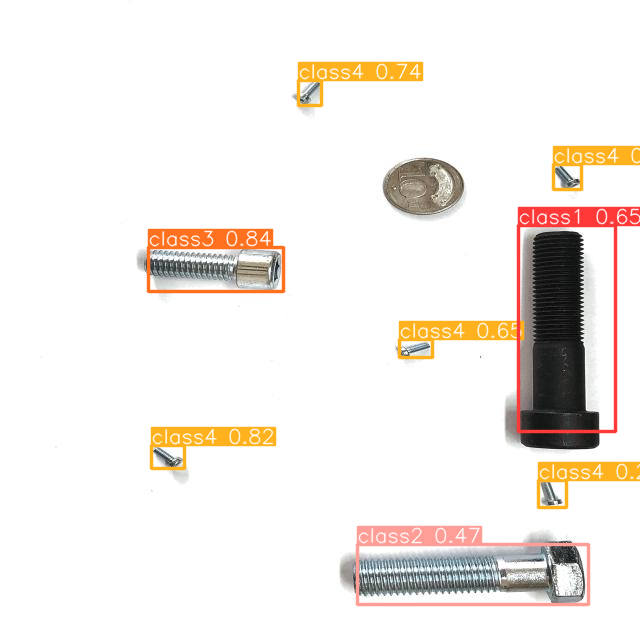

In [13]:
from PIL import Image

r = results[0]
im_array = r.plot()  # plot a BGR numpy array of predictions
# 顯示預測結果
Image.fromarray(im_array[:,:,::-1], 'RGB')

### 使用 supervision 繪製物件框(方法二)
本方法還是使用 Ultralytics Python API 進行預測，但最終物件框繪製採用 supervision 繪製。而方法一是直接拿 ultralytics 內建 API 繪製的結果。

In [16]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [17]:
!pip install -q  supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 1.3 MB/s eta 0:00:00



image 1/1 /content/screw-4/valid/images/train-3_png.rf.a4bb4fac0eef6076db2f79165d7f6c7b.jpg: 640x640 1 class1, 1 class2, 1 class3, 5 class4s, 33.8ms
Speed: 2.0ms preprocess, 33.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


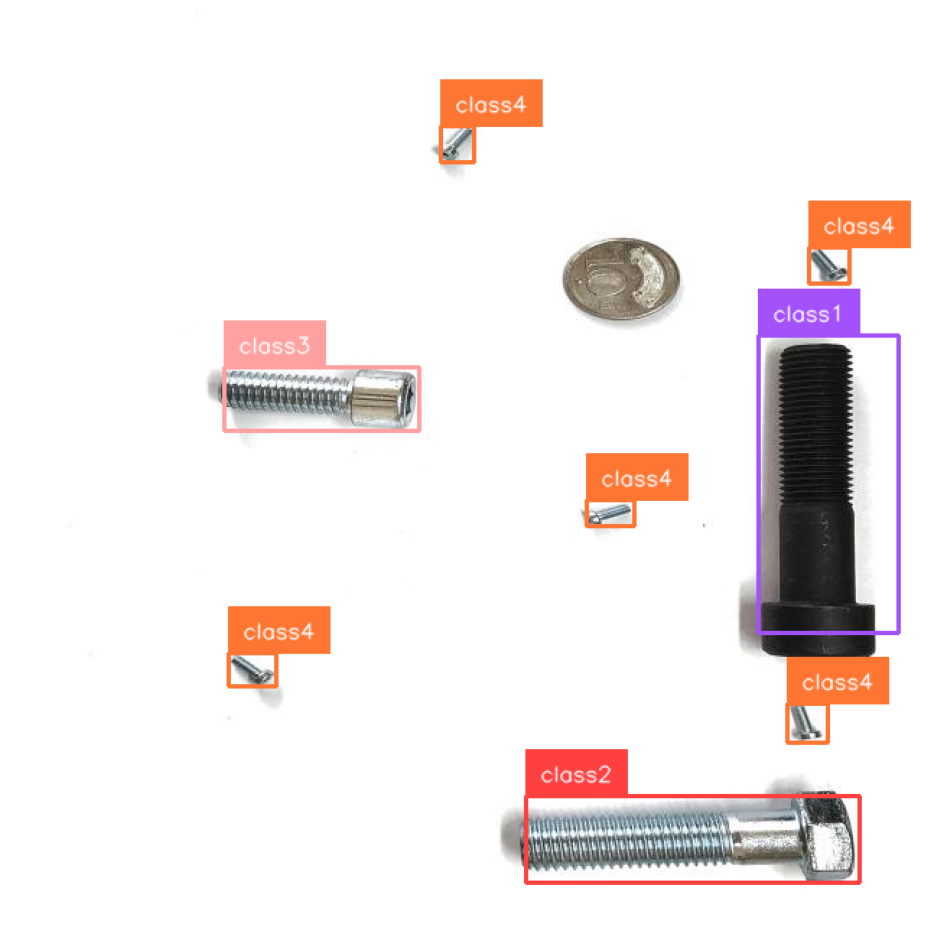

In [18]:
import cv2
import supervision as sv
from ultralytics import YOLOv10

# 設置圖片路徑
image_path = f'{dataset.location}/valid/images/train-3_png.rf.a4bb4fac0eef6076db2f79165d7f6c7b.jpg'

# 使用 OpenCV 讀取圖片
input_image = cv2.imread(image_path)
# 執行預測
model = YOLOv10('/content/runs/detect/train/weights/best.pt')
results = model(source=image_path, conf=0.25)[0]
# 為圖片添加邊界框和標籤
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=input_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)
# 顯示預測結果
sv.plot_image(annotated_image)